# Decision Trees

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/02-supervised-learning/02-decision-trees.ipynb)


**Decision Trees** are versatile ML algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets and they are the fundamental components of Random Forests. Decision Trees are intuitive, and their decisions are easy to interpret. Such models are often called **white box models**. In contrast, Neural Networks are generally considered **black box models**. ANNs make great predictions, but it is usually hard to explain in simple terms why the predictions were made. Conversely, Decision Trees provide nice, simple classification rules that can even be applied manually if needed. At the same time, finding an "optimal" decision tree for a set of training data is computationally a very hard problem. We will get around this by trying to build a good-enough tree rather than an optimal one, although for large datasets this can still be a lot of work. More important, it is very easy (and very bad) to build decision trees that are overfitted to the training data, and that don’t generalize well to unseen data.

1. [Definition](#Definition)
2. [Entropy](#Entropy)
3. [ID3 Algorithm](#ID3-Algorithm)
4. [Classification](#Classification)
5. [CART Algorithm](#CART-Algorithm)
6. [Regression](#Regression)
7. [Instability](#Instability)
8. [Exercise](#Exercise)

If you are working on Google Colab, please run the following lines:

In [ ]:
import urllib.request

!mkdir data

def fetch_data(remote, local):
    urllib.request.urlretrieve(remote, local)
    
fetch_data("https://github.com/riccardoberta/machine-learning/tree/master/02-supervised-learning/data/restaurant.csv", "data/restaurant.csv" )

## Definition

A decision tree uses a tree structure to represent a number of possible decision paths and an outcome for each path. For example:

<img src="images/decision-tree.png" width="400">

Suppose we want to decide if today we will play soccer or not. We start at the **root node**, it asks about weather. If it a sunny day, then we move down to the left **child node**. It asks for the humidity. If it is a normal day, the we move down to the next node, which is a **leaf node** (no other child nodes), so it does not ask questions, it gives the answer (yes, we will play).

We define a tree node to be either: a **leaf node** that predicts a single value or a **split node** containing an attribute to split on, a list of subtrees for specific values of that attribute, and possibly a default value to use if we see an unknown value.

In [38]:
class Leaf():
    def __init__(self, value):
        self.value = value

class Split():
    def __init__(self, attribute, subtree, default_value):
        self.attribute = attribute
        self.subtrees = subtree
        self.default_value = default_value

With this representation our soccer tree would look like:

In [39]:
cloudy = Leaf('Yes')
sunny = Split('humidity', { 'high': Leaf('No'), 'normal': Leaf('Yes') }, None)
rainy = Split('wind', { 'strong': Leaf('No'), 'weak': Leaf('Yes') }, None)

play_soccer = Split('weather', { 'sunny': sunny, 'cloudy': cloudy, "rainy": rainy }, None)

Given such a representation, we can classify an input with:

In [40]:
def classify(tree, input):
    """classify the input using the given decision tree"""
    if isinstance(tree, Leaf):
        return tree.value
    subtree_key = dict.get(input, tree.attribute)
    if subtree_key not in tree.subtrees:   
        return tree.default_value          
    subtree = tree.subtrees[subtree_key]   
    return classify(subtree, input)

In [41]:
day_1 = {'weather': 'sunny', 'humidity': 'normal', 'wind': 'weak'}
day_2 = {'weather': 'sunny', 'humidity': 'high', 'wind': 'weak'}

print(classify(play_soccer, day_1))
print(classify(play_soccer, day_2))

Yes
No


We can traverse all the tree in order to show it:

In [61]:
def show(tree, step=0):
    """classify the input using the given decision tree"""
    if isinstance(tree, Leaf):
        print((step+1)*'\t' + tree.value)
        return
    print(step*'\t' + '[' + tree.attribute + ']')
    step = step+1
    for key, subtree in tree.subtrees.items():
        print(step*'\t' + ' -> ' + key)
        show(subtree, step+1)
    return

show(play_soccer)

[weather]
	 -> sunny
		[humidity]
			 -> high
					No
			 -> normal
					Yes
	 -> cloudy
			Yes
	 -> rainy
		[wind]
			 -> strong
					No
			 -> weak
					Yes


We can use a Decision Tree to encode the knoledge of an expert in a particular domain. For example, think about another toy example: how to decide whether to wait for a table at a restaurant (in that case we are the experts). First, we need to identify the list the attributes that we consider as important to make the decision. For example:
- Alternate: whether there is an alternative restaurant nearby
- Bar: whether the restaurant has a comfortable bar area to wait in
- Fri/Sat: true on Fridays and Saturdays
- Hungry: whether we are hungry
- Patrons: how many people are in the restaurant (values are None, Some, and Full)
- Raining: whether it is raining outside
- Price: the restaurant's price range ($, $$, $$$)
- Reservation: whether we made a reservation
- Type: the kind of restaurant (French, Italian, Thai, or burger)
- WaitEstimate: the wait estimated by the host (0-10 minutes, 10-30, 30-60, or >60)

Then we can try to design a decision tree, by inserting our experience into del Decision Tree, and we can come up with the following solution:

<img src="images/restaurant.png" width="600">

However, we can encounter the **knowledge acquisition problem**: designing, debugging, and maintaining rules defined by experts is really difficult and in some cases impossible. Knowledge possessed by experts is complex as most of it is tacit, and hence cannot be captured without converting tacit knowledge to explicit knowledge (externalization), which is very difficult.

What we can have instead is a dataset with examples that we can levarage to find rules. In the toy example, we can have a list of past decisions that we made in different situations. An example consists of an $(X,y)$ pair, where $X$ is a vector of values for the input attributes and $y$ is a single boolean output value.

In [76]:
import pandas as pd

data_set = pd.read_csv('data/restaurant.csv')
data_set.index += 1 
data_set.head(12)

,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,Wait
1,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
2,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No
3,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
4,Yes,No,Yes,Yes,Full,$,No,No,Thai,10-30,Yes
5,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
6,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
7,No,Yes,No,No,None,$,Yes,No,Burger,0-10,No
8,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,Yes
9,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,No
10,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No


How we can devise a Decision Tree from the set of examples? Intuitivelly, we have to create a tree consistent with the examples and as small as possible. Unfortunately, this is an intractable problem. However, we can find a good approximate solution adopting a divide-and-conquer approach. The strategy is test the "most important attribute" (the one that makes the most difference to the classification) first, in order to divide the problem into smaller sub-problems that can then be solved recursively. But, what is an "important" attribute? Let's consider "Type" and "Patrons" in the toy example:

<img src="images/decision-tree-attributes.png" width="600">

Notice that "Type" is a poor attribute, it leaves us with four possible outcomes and each of them has the same number of positive as negative examples. Instead, "Patrons" is a fairly important attribute: if its value is "None" or "Some", we have only examples we can answer definitively, if its value is "Full" we have a mixed set of examples. In general, after the first attribute test splits up the examples, each outcome is a new decision tree learning problem in itself with fewer examples and one less attribute. In choosing an attribute, we need a formal measure of "importance" of an attribute. For this we can apply the notion fo entropy.

## Entropy

In order to build a decision tree, we will need to decide **what questions to ask and in what order**. At each stage of the tree there are some possibilities we’ve eliminated and some that we haven’t. Each possible question partitions the remaining possibilities according to its answer. Ideally, we’d like to choose questions whose answers give a lot of information about what our tree should predict. If there’s a single yes/no question for which "yes" answers always correspond to Yes outputs and "no" answers to No outputs (or vice versa), this would be an awesome question to pick. Conversely, a yes/no question for which neither answer gives you much new information about what the prediction should be is probably not a good choice.

We capture the notion of "how much information" with the [**entropy** concept](https://machinelearningmastery.com/what-is-information-entropy/) (from Shannon’s information theory), that we use to represent the **uncertainty associated with data**. Imagine we have a set $S$ of data, each member of which is labeled as belonging to one of a finite number of classes $C_1, C_2, ..., C_n$. If all the data points belong to a single class, then there is no real uncertainty, which means we’d like there to be low entropy. If the data points are evenly spread across the classes, there is a lot of uncertainty and we’d like there to be high entropy. If $p_i$ is the proportion of data labeled as class $C_i$, then we can define entropy as:

$\begin{align}
H(S) = -p_1 \text{log}_2 p_1 - p_2 \text{log}_2 p_2 - ... - p_n \text{log}_n p_n = \sum\limits_{i=1}^{n}{p_ilog_2p_i} 
\end{align}$

We can plot the term $p_i \text{log}_2 p_i$:

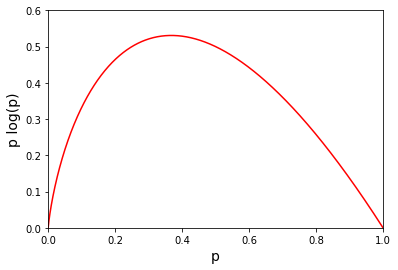

In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt

P = np.arange(0.0001, 1, 0.001).tolist()
P_log_P = [-p * math.log(p, 2) for p in P]

plt.plot(P, P_log_P, "r-")
plt.xlabel("p", fontsize=14)
plt.ylabel("p log(p)", fontsize=14)

plt.axis([0, 1, 0, 0.6])
plt.show()

The entropy will be small when $p_i$ is close to 0 or 1 (i.e., when most of the data is in a single class), and it will be larger when $p_i$ is not close to 0 or 1 (i.e., when the data is spread across multiple classes). This is exactly the behavior we desire.

In [65]:
def entropy(class_probabilities):
    """Given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2) for p in class_probabilities if p > 0)

In [66]:
print(entropy([1.0]))
print(entropy([0.5, 0.5]))
print(entropy([0.25, 0.75]))

0.0
1.0
0.8112781244591328


Our data will consist of pairs (input, label), which means that we’ll need to compute the class probabilities.

In [67]:
def class_probabilities(labels):
    total_count = len(labels)
    return [count / total_count for count in Counter(labels).values()]

def data_entropy(labels):
    return entropy(class_probabilities(labels))

What we’ve done is compute the entropy ("uncertainty") of a single set of labeled data. Now, each stage of a decision tree involves asking a question whose answer partitions data into several subsets. Correspondingly, we’d like some notion of the entropy that results from partitioning a set of data in a certain way. We want a partition to have low entropy if it splits the data into subsets that themselves have low entropy, and high entropy if it contains subsets that have high entropy. Mathematically, if we partition our data $S$ into subsets $S_1, S_2,..., S_m$ containing proportions $q_1, q_2,..., q_m$ of the data, then we can compute the entropy of the partition as a weighted sum:

$\begin{align}
H = q_1 H(S_1) + q_2 H(S_2) + ... + q_m H(S_m) = \sum\limits_{i=1}^{m}{q_i H(S_i)}
\end{align}$

In [68]:
def partition_entropy(subsets):
    """Returns the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)
    return sum(data_entropy(subset) * len(subset) / total_count for subset in subsets)

## ID3 Algorithm

The ID3 algorithm, stands for **Iterative Dichotomiser 3**, is a classification algorithm that follows a greedy approach of building a decision tree by selecting a best attribute that yields minimum Entropy. The steps in ID3 algorithm takes in input a dateset of examples:

In [109]:
inputs = []
for key, value in data_set.T.to_dict().items():
    inputs.append(value)
    print(value)

{'Alt': 'Yes', 'Bar': 'No', 'Fri': 'No', 'Hun': 'Yes', 'Pat': 'Some', 'Price': '$$$', 'Rain': 'No', 'Res': 'Yes', 'Type': 'French', 'Est': '0-10', 'Wait': 'Yes'}
{'Alt': 'Yes', 'Bar': 'No', 'Fri': 'No', 'Hun': 'Yes', 'Pat': 'Full', 'Price': '$', 'Rain': 'No', 'Res': 'No', 'Type': 'Thai', 'Est': '30-60', 'Wait': 'No'}
{'Alt': 'No', 'Bar': 'Yes', 'Fri': 'No', 'Hun': 'No', 'Pat': 'Some', 'Price': '$', 'Rain': 'No', 'Res': 'No', 'Type': 'Burger', 'Est': '0-10', 'Wait': 'Yes'}
{'Alt': 'Yes', 'Bar': 'No', 'Fri': 'Yes', 'Hun': 'Yes', 'Pat': 'Full', 'Price': '$', 'Rain': 'No', 'Res': 'No', 'Type': 'Thai', 'Est': '10-30', 'Wait': 'Yes'}
{'Alt': 'Yes', 'Bar': 'No', 'Fri': 'Yes', 'Hun': 'No', 'Pat': 'Full', 'Price': '$$$', 'Rain': 'No', 'Res': 'Yes', 'Type': 'French', 'Est': '>60', 'Wait': 'No'}
{'Alt': 'No', 'Bar': 'Yes', 'Fri': 'No', 'Hun': 'Yes', 'Pat': 'Some', 'Price': '$$', 'Rain': 'Yes', 'Res': 'Yes', 'Type': 'Italian', 'Est': '0-10', 'Wait': 'Yes'}
{'Alt': 'No', 'Bar': 'Yes', 'Fri': 'No', 

1. if the data all have the same label, the we are done, we can create a leaf node that predicts that label and then stop;
2. if the data have different labels:
    - we make a partitioning of the data by each of the attributes, 
    - choose the partition with the lowest partition entropy, 
    - add a decision node based on the chosen attributae 
    - recur on each partitioned subset using the remaining attributes;
3. if the list of attributes is empty (i.e., there are no more possible questions to ask), but we still have examples with different labels, this mean that we have some problems in the dataset (noise, or the domain is not deterministic, or we miss attributes that can distinguish among examples):
    - we create a leaf node that predicts the most common label and then stop;
4. if for some attribute value there are no examples left, this means that no example has been observed for this combination of attribute values:
    - we have to return a default value.

This is a **greedy** algorithm because, at each step, it chooses the most immediately best option. Given a dataset, there may be a better tree with a worse-looking first move. If so, this algorithm won’t find it. Nonetheless, it is relatively easy to understand and implement.

We need to partition the inputs into lists based on the specified attribute:

In [110]:
from collections import defaultdict

def partition(inputs, attribute):
    partitions = defaultdict(list)
    for input in inputs:
        key = dict.get(input, attribute)  # value of the specified attribute
        partitions[key].append(input)     # add input to the correct partition
    return partitions

And we need to compute the entropy corresponding to a given partition:

In [111]:
def partition_entropy_by(inputs, attribute, label_attribute):
    # partitions consist of our inputs
    partitions = partition(inputs, attribute)
    # but partition_entropy needs just the class labels
    labels = [[dict.get(input, label_attribute) for input in partition] for partition in partitions.values()]
    return partition_entropy(labels)

Finally, we can build our tree using the available dataset:

In [112]:
from collections import Counter

def id3(inputs, attributes, target):
    label_counts = Counter(dict.get(input, target) for input in inputs)
    most_common_label = label_counts.most_common(1)[0][0]
    if len(label_counts) == 1:
        return Leaf(most_common_label)
    if not attributes:
        return Leaf(most_common_label)
    def split_entropy(attribute: str) -> float:
        """Helper function for finding the best attribute"""
        return partition_entropy_by(inputs, attribute, target)
    best_attribute = min(attributes, key=split_entropy)
    partitions = partition(inputs, best_attribute)
    new_attributes = [a for a in attributes if a != best_attribute]
    subtrees = {attribute_value : id3(subset, new_attributes, target) for attribute_value, subset in partitions.items()}
    return Split(best_attribute, subtrees, default_value=most_common_label)

In the code we manage also the case of an unexpected (or missing) attribute value. What should our soccer tree do if it encounters a day whose humidity is low? We’ll handle this case by populating the default_value attribute with the most common label or with a random one.

We can try our algorith with a toy dataset:

In [116]:
print(data_set.columns)

Index(['Alt', 'Bar', 'Fri', 'Hun', 'Pat', 'Price', 'Rain', 'Res', 'Type',
       'Est', 'Wait'],
      dtype='object')


In [122]:
predictors = data_set.drop("Wait", axis=1)
label = data_set['Wait']

tree = id3(inputs, predictors.columns.array, 'Wait')

In [124]:
show(tree)

[Pat]
	 -> Some
			Yes
	 -> Full
		[Hun]
			 -> Yes
				[Type]
					 -> Thai
						[Fri]
							 -> No
									No
							 -> Yes
									Yes
					 -> Italian
							No
					 -> Burger
							Yes
			 -> No
					No
	 -> None
			No


Notice that the set of examples is crucial for constructing the tree. The learned tree is different from the original one that we designed by hands. The algorithm looks at the examples, not at the correct function. Its hypothesis is consistent with all the examples, and it is considerably simpler than the original one. For example, the learner has no reason to tests for "raining" or "reservation2, becouse it can classify all the examples without these attributes.  It is also bound to make mistakes for cases with no examples: it has no cases with "wait" is 0-10 min but the restaurant is full, in that case it says not to wait when "hungry" is false
but the real user would certainly wait. With more training examples the learning program could correct this mistake.

## CART Algorithm

SciKitLearn features a **DecisionTreeClassifier** class. It is a binary decision tree able to manage continuous data value (and not only categorical as our naive implementation of ID3). It uses the **Classification and Regression Tree (CART)** algorithm, that works on the **gini** notion, instead of the entropy. The gini value of a node is defined as:

$\begin{align}
G_i=1-\sum\limits_{k=1}^{n}p^{2}_{i,k}
\end{align}$

where $p_{i,k}$ is the ratio of class k instances among the training instances in the i node. A node is defined as **pure** (gini=0) if all training instances it applies to belong to the same class. The CART algorithm splitas a set into two subsets using an attribute $k$ and a threshold $t_k$. It searches for the pair $(k,t_k)$ that produces the **purest subsets** (weighted by their size). Given a dataset with two inputs of height in centimeters and weight in kilograms, the output of sex as male or female will be classified as in the following figure: 

<img src="images/cart.png" width="500">

This is the cost fuction that CART tries to minimize:

$\begin{align}
J(k,t_k)=\frac{m_\text{left}}{m}G_\text{left}+\frac{m_\text{right}}{m}G_\text{right}
\end{align}$

where $G_\text{left/right}$ measures the impurity of the left/right subset and $m_\text{left/right}$ is the number of instances in the left/right subset.

Once the algorithm has splitted the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the **max_depth** hyperparameter), or if it cannot find a split that will reduce impurity. We can make an example, training a Decision Trees classifier for the Iris dataset: 

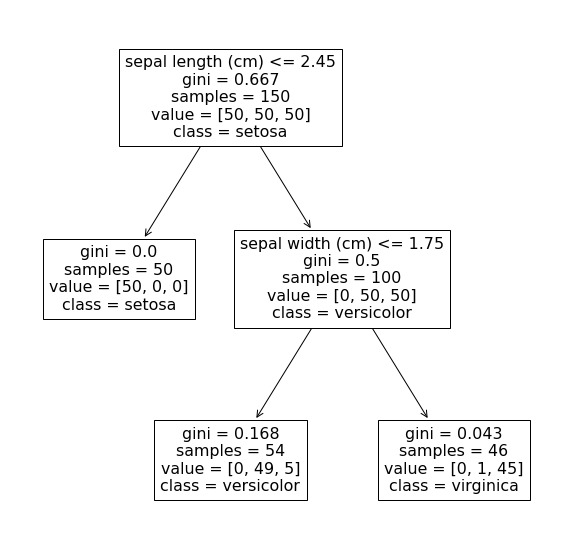

In [126]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

fig = plt.figure(figsize=(10,10))
plot = tree.plot_tree(tree_clf, feature_names=iris.feature_names, class_names=iris.target_names)

Notice that the information of each nodes are: the parameter and the threashold considered, the number of training instances it applies to the node (**samples**), the number of training instances of each class this node applies (**value**), the measure of impurity (**gini**) and the class predicted (**class**). We can draw the decision boundaries:

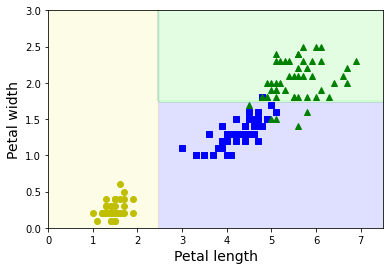

In [127]:
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

plot_decision_boundary(tree_clf, X, y, [0, 7.5, 0, 3])

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)

plt.show()

A Decision Tree can also estimate the probability that an instance belongs to a particular class k. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class k in this node. For example, check a flower whose petals are 5 cm long and 1.5 cm wide:

In [128]:
print(tree_clf.predict_proba([[5, 1.5]]))
print(tree_clf.predict([[5, 1.5]]))

[[0.         0.90740741 0.09259259]]
[1]


The CART algorithm is a **greedy algorithm**: it greedily searches for an optimum split at the top level, then repeats the process at each subsequent level. It does not check whether or not the split will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a solution that’s **reasonably good** but not guaranteed to be optimal. Unfortunately, finding the optimal tree is known to be an [**NP-Complete problem**](https://www.youtube.com/watch?v=YX40hbAHx3s). So, it requires $O(exp(m))$ time, making the problem intractable even for small training sets. 

Making predictions requires traversing the Decision Tree from the root to a leaf, which requires going through roughly $O(log_2(m))$ nodes. So predictions are very fast, even when dealing with large training sets.

By default, the Gini measure is used, but we can select the Entropy measure by setting the **criterion hyperparameter** accordingly. Gini and Entropy lead to similar trees. Gini impurity is slightly faster to compute, while entropy tends to produce slightly more balanced trees.

## Regularization
Decision Trees make very few assumptions about the training data (as opposed to linear models, which assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely, most likely overfitting it. For Example, if we try to predict when a roll of a dice will come up as 6 or not, we can run several experiments with several dice attributes (e.g. color, weight of the dice, time of the roll, and whether the experimenters had their fingers crosse). Of course, the correct tree should be a single node that says "no", but the algorithm will learn any pattern it can find in the input. If there are 2 rolls of a 7gr blue dice with fingers crossed both with 6, then it may construct a tree that predicts 6 in that case!

Such a model is often called a **non-parametric model**, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a **parametric model**, such as a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting). To avoid overfitting, you need to restrict the Decision Tree’s freedom during training.  The **DecisionTreeClassifier** class has a few parameters that restrict the shape of the tree: 
- **max_depth** the maximum depth of the tree
- **min_samples_split** the minimum number of samples a node must have before it can be split 
- **min_samples_leaf** the minimum number of samples a leaf node must have
- **min_weight_fraction_leaf** same as min_samples_leaf but expressed as a fraction of the total number of weighted instances)
- **max_leaf_nodes** the maximum number of leaf nodes
- **max_features** the maximum number of features that are evaluated for splitting at each node 

Other algorithms work by first training the tree without restrictions, then pruning (deleting) unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity improvement it provides is not statistically significant. Standard statistical tests, such as the [$\chi^2$ test](https://en.wikipedia.org/wiki/Chi-squared_test), are used to estimate the probability that the improvement is purely the result of chance.

As an example, we can train two trees (one with the default hyperparameters and one withm min_samples_leaf=4) over the **moons dataset**: a toy dataset for binary classification in which the data points are shaped as two interleaving half circles.

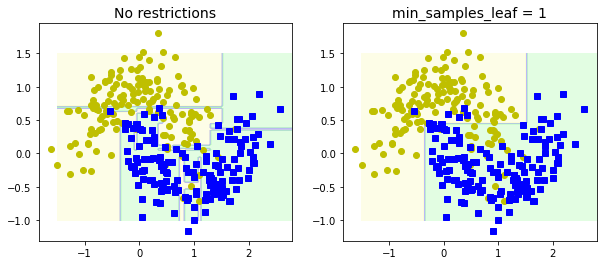

In [7]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=300, noise=0.25, random_state=53)

tree_clf_1 = DecisionTreeClassifier(random_state=42)
tree_clf_1.fit(Xm, ym)

tree_clf_2 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plot_decision_boundary(tree_clf_1, Xm, ym, axes=[-1.5, 2.8, -1, 1.5])
plt.plot(Xm[:, 0][ym==0], Xm[:, 1][ym==0], "yo")
plt.plot(Xm[:, 0][ym==1], Xm[:, 1][ym==1], "bs")
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(tree_clf_2, Xm, ym, axes=[-1.5, 2.8, -1, 1.5])
plt.plot(Xm[:, 0][ym==0], Xm[:, 1][ym==0], "yo")
plt.plot(Xm[:, 0][ym==1], Xm[:, 1][ym==1], "bs")
plt.title("min_samples_leaf = {}".format(tree_clf_2.min_samples_leaf), fontsize=14)

plt.show()

It is quite obvious that the model on the left is overfitting, and the model on the right will probably generalize better.

## Regression
Decision Trees are also capable of performing regression tasks. 
Let’s build a tree using Scikit-Learn’s **DecisionTreeRegressor** class, training it on a noisy quadratic dataset, with max_depth=2

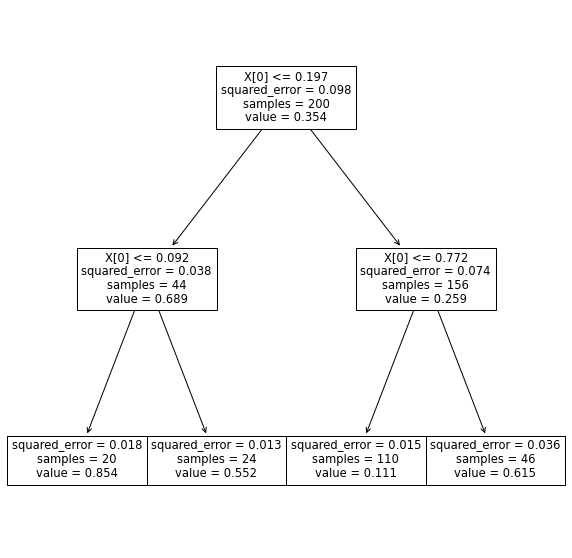

In [11]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2 + np.random.randn(m, 1) / 10

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

fig = plt.figure(figsize=(10,10))
plot = tree.plot_tree(tree_reg)

This tree instead of predicting a class in each node, it predicts a value. 
For example, suppose we want to make a prediction for a new instance with $x=0.6$, we traverse the tree starting at the root, and we each the leaf node that predicts value=0.111. This prediction is the average target value of the 110 training instances associated with this leaf node, and it results in a mean squared error equal to 0.015 over these 110 instances.

We can show the prediction also enlarging che max_depth value:

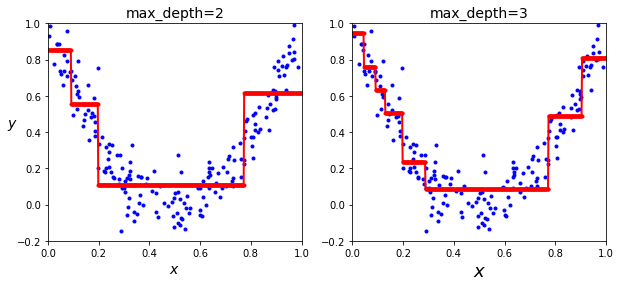

In [12]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg1.fit(X, y)

tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14, rotation=0)
plot_regression_predictions(tree_reg1, X, y)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=18)
plot_regression_predictions(tree_reg2, X, y)
plt.title("max_depth=3", fontsize=14)

plt.show()

Notice how the predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value. The CART algorithm works mostly the same way as earlier, except that instead of trying to split the training set in a way that minimizes impurity, it now tries to split the training set in a way that minimizes the MSE:

$\begin{align}
J(k,t_k)=\frac{m_\text{left}}{m}\text{MSE}_\text{left}+\frac{m_\text{right}}{m}\text{MSE}_\text{right}
\end{align}$

where

- $\text{MSE}_\text{node}=\sum\limits_{i\in\text{node}}(\hat{y}_\text{node}-y^{(i)})^2$
- $\hat{y}_\text{node}=\frac{1}{m_\text{node}}\sum\limits_{i\in\text{node}}y^{(i)}$


Like for classification tasks, Decision Trees are prone to overfitting when dealing with regression tasks. Without any regularization (i.e., using the default hyperparameters), you get predictions obviously overfitting the training set very badly. Just setting min_samples_leaf=10 results in a much more reasonable model.

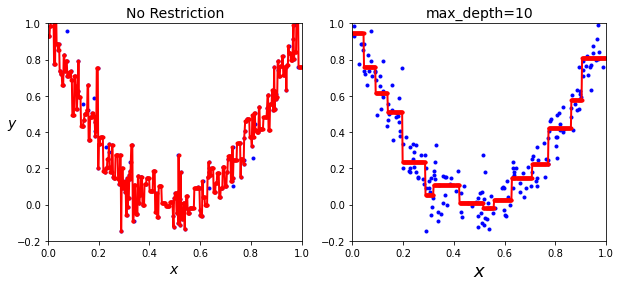

In [169]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg1.fit(X, y)

tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14, rotation=0)
plot_regression_predictions(tree_reg1, X, y)
plt.title("No Restriction", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.xlabel("$x$", fontsize=18)
plot_regression_predictions(tree_reg2, X, y)
plt.title("max_depth=10", fontsize=14)

plt.show()

## Instability
Hopefully by now you are convinced that Decision Trees have a lot going for them: they are simple to understand and interpret, easy to use, versatile, and powerful. However, they do have a few limitations.  Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation. For example, considerging a simple linearly separable dataset, a Decision Tree can split it easily, but after the dataset is rotated, the decision boundary looks unnecessarily convoluted. Although both Decision Trees fit the training set perfectly, it is very likely that the model will not generalize well.

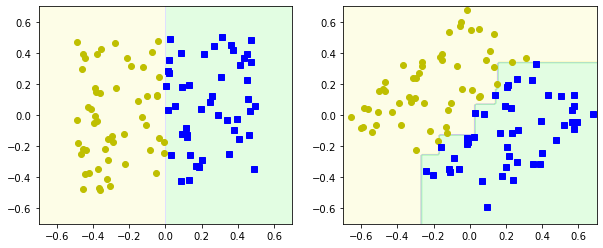

In [170]:
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)

tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

plt.sca(axes[0])
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "yo")
plt.plot(Xs[:, 0][ys==2], Xs[:, 1][ys==2], "bs")
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7])

plt.sca(axes[1])
plt.plot(Xsr[:, 0][ys==0], Xsr[:, 1][ys==0], "yo")
plt.plot(Xsr[:, 0][ys==2], Xsr[:, 1][ys==2], "bs")
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7])

plt.show()

More generally, the main issue is that they are very **sensitive to small variations in the training data**. Random Forests can limit this instability by averaging predictions over many trees. For example, if you just remove the widest Iris versicolor from the iris training set (the one with petals 4.8 cm long and 1.8 cm wide) and train a new Decision Tree, you may get a relly different model.

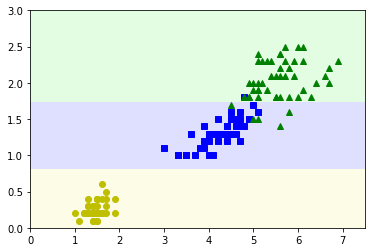

In [171]:
X = iris.data[:, 2:] # petal length and width
y = iris.target

X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris versicolor flower
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, [0, 7.5, 0, 3])

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")

plt.show()

## Exercise

**1 - Train and fine-tune a Decision Tree for the moons dataset by following these steps: (a) use make_moons(n_samples=10000, noise=0.4) to generate a moons
dataset; (b) use train_test_split() to split the dataset into a training set and a test
set; (c) use grid search with cross-validation (with the help of the GridSearchCV
class) to find good hyperparameter values for a DecisionTreeClassifier; (d) train it on the full training set using these hyperparameters, and measure your model’s performance on the test set.**

In [10]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=0, cv=3)
grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_estimator_)

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=42)


0.8695

**2 - Grow a forest by following these steps: (a) continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly; (b) train one Decision Tree on each subset, using the best hyperparameter
values found in the previous exercise, evaluate these 1,000 Decision Trees
on the test set (since they were trained on smaller sets, these Decision Trees
will likely perform worse than the first Decision Tree, achieving only about
80% accuracy); (c) Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction; (d) evaluate these predictions on the test set: you should obtain a slightly higher
accuracy than your first model**

In [11]:
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone
from scipy.stats import mode

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))
    
forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []
for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
print(np.mean(accuracy_scores))  

Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)
for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)
y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8054499999999999


0.872